# Data Literacy
#### University of Tübingen, Winter 2025/26
## Lecture 05

---
&copy; Philipp Hennig, 2025. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [2]:
%run -i 'Preamble.py'

In [6]:
import requests
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from scipy import stats
import calendar
from tqdm import tqdm

from matplotlib import animation
from IPython.display import HTML

rb = LinearSegmentedColormap.from_list(
    "rb", [rgb.tue_blue, [1, 1, 1], rgb.tue_red], N=500
)

wg = LinearSegmentedColormap.from_list(
    "wg", [[1, 1, 1], rgb.tue_gold], N=500
)

RELOAD_DATA = False
if RELOAD_DATA:
    print("WARNING: You have set RELOAD_DATA to True. I will download about 500MB of data. You have been warned.")

# I use this switch to trigger constructing the animations. They take a while, so I don't want these cells to run in the lecture.
BUILD_ANIMATIONS = True

Last week we took a look at Antarctic (and Arctic) Sea Ice coverage across 2023 and over the historical background, as a univariate timeline. We saw that something significant seems to have happened this year. But this aggregate data does not provide any further information about *what*, really, may be happening in the Antarctic. To get an even slightly more concrete idea, we need to look at the geographic distribution of ice data. 

Der Spiegel did something like this here:

<div>
<img src="Spiegel.png" width="400"/>
</div>

This is based on an image available from NOAA:

<div>
<img src="https://noaadata.apps.nsidc.org/NOAA/G02135/south/daily/images/2023/08_Aug/S_20230805_extn_hires_v4.0.png" width=500/>
</div>

Let's see if we can do a similar thing ourselves.

The raw data from NOAA is actually available as tiff images. tiff is kind of nice to work with in the sense that it is easy to parse: Tiff images are simply arrays of pixel RGBA values, so there is no issue with compression artifacts, and the data is directly accessible as `numpy` arrays. The downside is that the file are rather large. But if we focus on one day per year, it's not that bad.

In [3]:
# let's pick one particular day of the year. Say, 20 July. The tiff for this day is here:


def tiff_url(year):
    return (
        "https://noaadata.apps.nsidc.org/NOAA/G02135/south/daily/geotiff/"
        + str(year)
        + "/07_Jul/S_"
        + str(year)
        + "0720_extent_v4.0.tif"
    )


if RELOAD_DATA:  # download all tif images for the years 1981-2023
    for year in tqdm(np.arange(1981, 2026)):
        url = tiff_url(year)
        with open("south_" + str(year) + "_07_20.tif", "wb") as f:
            f.write(requests.get(url).content)

# annoyingly, this doesn't always work. For the years 1982, 1985, and 1987, the file is not available. We'll use the image from one day later instead:
for year in [1982, 1985, 1987]:
    url = tiff_url(year).replace("0720", "0721")
    with open("south_" + str(year) + "_07_20.tif", "wb") as f:
        f.write(requests.get(url).content)

These tiff images are basically arrays of size `(x,y,4)` where the entries at `x,y` are `[r,g,b,alpha]` values.

[255 255 255 255]
[119 119 119 255]


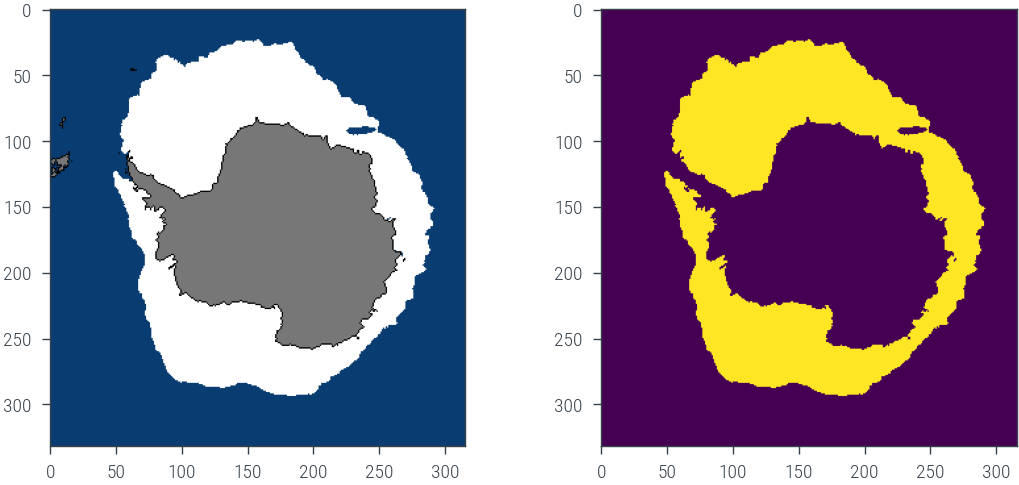

In [4]:
ima = plt.imread("south_2020_07_20.tif")
fig, axs = plt.subplots(1, 2)
axs[0].imshow(ima)
# two example pixels: one white, one grey
print(ima[100, 100])
print(ima[200, 200])

# to extract the ice cover, we take all the white pixels (i.e. [255, 255, 255]).
im_white = (ima == 255).all(axis=2).astype(int)

axs[1].imshow(im_white)

So we can build a density estimate of the ice extent by adding up all the white pixels from the years 1981 to 2010:

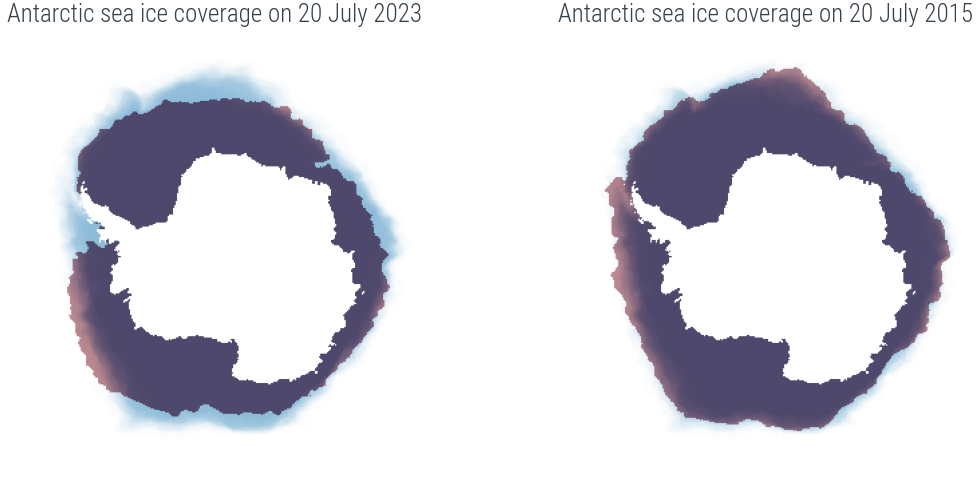

In [5]:
cmp = LinearSegmentedColormap.from_list("w2b", [(1, 1, 1), rgb.tue_blue], N=1024)
cmo = LinearSegmentedColormap.from_list("w2o", [(1, 1, 1), rgb.tue_red], N=1024)

coverage = np.zeros_like(im_white)

for year in np.arange(1981, 2024):
    im = plt.imread("south_" + str(year) + "_07_20.tif")
    coverage += (im == 255).all(axis=2).astype(int)

tot = len(np.arange(1981, 2024))
coverage = coverage / tot

im = plt.imread("south_2023_07_20.tif")
coverage_2023 = (im == 255).all(axis=2).astype(int)


fig, axs = plt.subplots(1, 2)
ax = axs[0]
ax.imshow(coverage, cmap=cmp)
ax.imshow(
    coverage_2023,
    cmap=cmo,
    alpha=0.55,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Antarctic sea ice coverage on 20 July 2023")
ax.axis("off")

ax = axs[1]
ax.axis("off")
im = plt.imread("south_2015_07_20.tif")
coverage_2015 = (im == 255).all(axis=2).astype(int)

ax.imshow(coverage, cmap=cmp)
ax.imshow(
    coverage_2015,
    cmap=cmo,
    alpha=0.55,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Antarctic sea ice coverage on 20 July 2015")

plt.savefig("coverage_20_July_2023_15.pdf")

We can see that in 2023, the continent lost ice actually pretty much all around its circumference. Three areas of particularly stark losses where in the [Bellinghausen Sea](https://en.wikipedia.org/wiki/Bellingshausen_Sea), the [Riiser-Larsen Sea](https://en.wikipedia.org/wiki/Riiser-Larsen_Sea) and the [Somov Sea](https://en.wikipedia.org/wiki/Somov_Sea).

At least visually, the changes in the Bellinghausen Sea seem particularly worrying. Here, the see ice completely retracted all the way to the shores of the [antarctic peninsula](https://en.wikipedia.org/wiki/Antarctic_Peninsula). One first hypothesis we could have is that this may have something to do with the proximity of this part of Antarctica to Cape Horn and South Africa.

# From Ice to the Sea...

We take a look at the global Sea Surface Temperature. Arguably the most extensive source of data on this level is the [ERA5 global reanalysis](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-complete?tab=overview). However, it requires an account (it's free and easy to set up. If you are planning to do any more serious analysis, I recommend you get one), and the API is a bit complicated. For simplicity, we will instead use NOAA's data:

In [7]:
# from netCDF4 import Dataset
# import xarray as xr
# import cartopy.crs as ccrs  # plotting library for geospatial data

RELOAD_DATA = True

if RELOAD_DATA:
    # let's download global Sea Surface Data from NOAA for all of 2023:
    # make sure you've got a subfolder called "netCDF4" in your working directory
    for month in tqdm(range(1, 11)):
        _, num_days = calendar.monthrange(2023, month)
        for day in range(1, num_days + 1):
            url = f"https://www.ncei.noaa.gov/thredds/fileServer/OisstBase/NetCDF/V2.1/AVHRR/2023{month:02d}/oisst-avhrr-v02r01.2023{month:02d}{day:02d}.nc"
            print(url)
            break
            with open(f"netCDF4/sst_2023{month:02d}{day:02d}.nc", "wb") as f:
                f.write(requests.get(url).content)

100%|██████████| 10/10 [00:00<00:00, 42755.39it/s]

https://www.ncei.noaa.gov/thredds/fileServer/OisstBase/NetCDF/V2.1/AVHRR/202301/oisst-avhrr-v02r01.20230101.nc
https://www.ncei.noaa.gov/thredds/fileServer/OisstBase/NetCDF/V2.1/AVHRR/202302/oisst-avhrr-v02r01.20230201.nc
https://www.ncei.noaa.gov/thredds/fileServer/OisstBase/NetCDF/V2.1/AVHRR/202303/oisst-avhrr-v02r01.20230301.nc
https://www.ncei.noaa.gov/thredds/fileServer/OisstBase/NetCDF/V2.1/AVHRR/202304/oisst-avhrr-v02r01.20230401.nc
https://www.ncei.noaa.gov/thredds/fileServer/OisstBase/NetCDF/V2.1/AVHRR/202305/oisst-avhrr-v02r01.20230501.nc
https://www.ncei.noaa.gov/thredds/fileServer/OisstBase/NetCDF/V2.1/AVHRR/202306/oisst-avhrr-v02r01.20230601.nc
https://www.ncei.noaa.gov/thredds/fileServer/OisstBase/NetCDF/V2.1/AVHRR/202307/oisst-avhrr-v02r01.20230701.nc
https://www.ncei.noaa.gov/thredds/fileServer/OisstBase/NetCDF/V2.1/AVHRR/202308/oisst-avhrr-v02r01.20230801.nc
https://www.ncei.noaa.gov/thredds/fileServer/OisstBase/NetCDF/V2.1/AVHRR/202309/oisst-avhrr-v02r01.20230901.nc
h

NOAA provides its data in [netCDF4](https://en.wikipedia.org/wiki/NetCDF) format, which builds on top of HDF5. It's column-centric dataformat with proper headers. This makes working with it safer and more efficient. The only price is that we need to use a dedicated library to access it.

In [7]:
data = xr.open_dataset("netCDF4/sst_20230729.nc")
df = data.to_dataframe()
df

sst  anom  err  ice
time                zlev lat     lon                          
2023-07-29 12:00:00 0.0  -89.875 0.125     NaN   NaN  NaN  NaN
                                 0.375     NaN   NaN  NaN  NaN
                                 0.625     NaN   NaN  NaN  NaN
                                 0.875     NaN   NaN  NaN  NaN
                                 1.125     NaN   NaN  NaN  NaN
...                                        ...   ...  ...  ...
                          89.875 358.875 -1.23  0.57  0.3  0.9
                                 359.125 -1.19  0.61  0.3  0.9
                                 359.375 -1.80  0.00  0.3  0.9
                                 359.625 -1.80  0.00  0.3  0.9
                                 359.875 -1.80  0.00  0.3  0.9

[1036800 rows x 4 columns]

In [8]:
data["sst"]

<xarray.DataArray 'sst' (time: 1, zlev: 1, lat: 720, lon: 1440)> Size: 4MB
array([[[[ nan, ...,  nan],
         ...,
         [-1.8, ..., -1.8]]]], shape=(1, 1, 720, 1440), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-07-29T12:00:00
  * zlev     (zlev) float32 4B 0.0
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_min:  -300
    valid_max:  4500

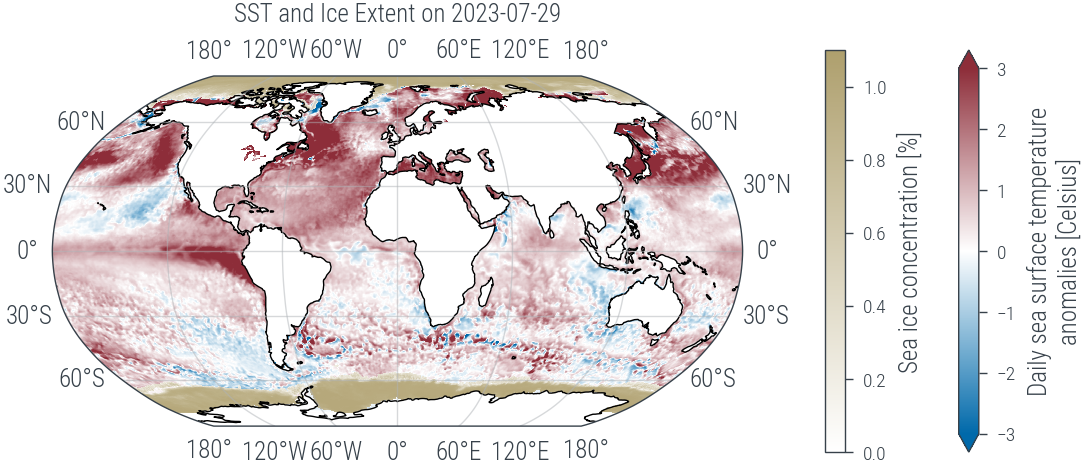

In [9]:
# Create a plot
plt.rcParams.update(bundles.beamer_moml())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.coastlines()
data["anom"].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=rb, vmin=-3, vmax=3)
data["ice"].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=wg, vmin=0, vmax=1.1)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=.5,
    color=rgb.tue_gray,
    alpha=0.5,
    linestyle="-",
)
gl.top_labels = True
gl.right_labels = True

plt.title("SST and Ice Extent on 2023-07-29")
plt.savefig("sst_ice_2023_07_29.png", dpi=300)

Let's make a few animations of SST and ice, across the year 2023.

We begin with an equator-centric view of just SST anomaly.

In [10]:
# Load the data from the netCDF
data = xr.open_mfdataset("netCDF4/sst_2023*.nc", engine="netcdf4")

# Extract the anomaly variable
anom = data["anom"]
ice = data["ice"]

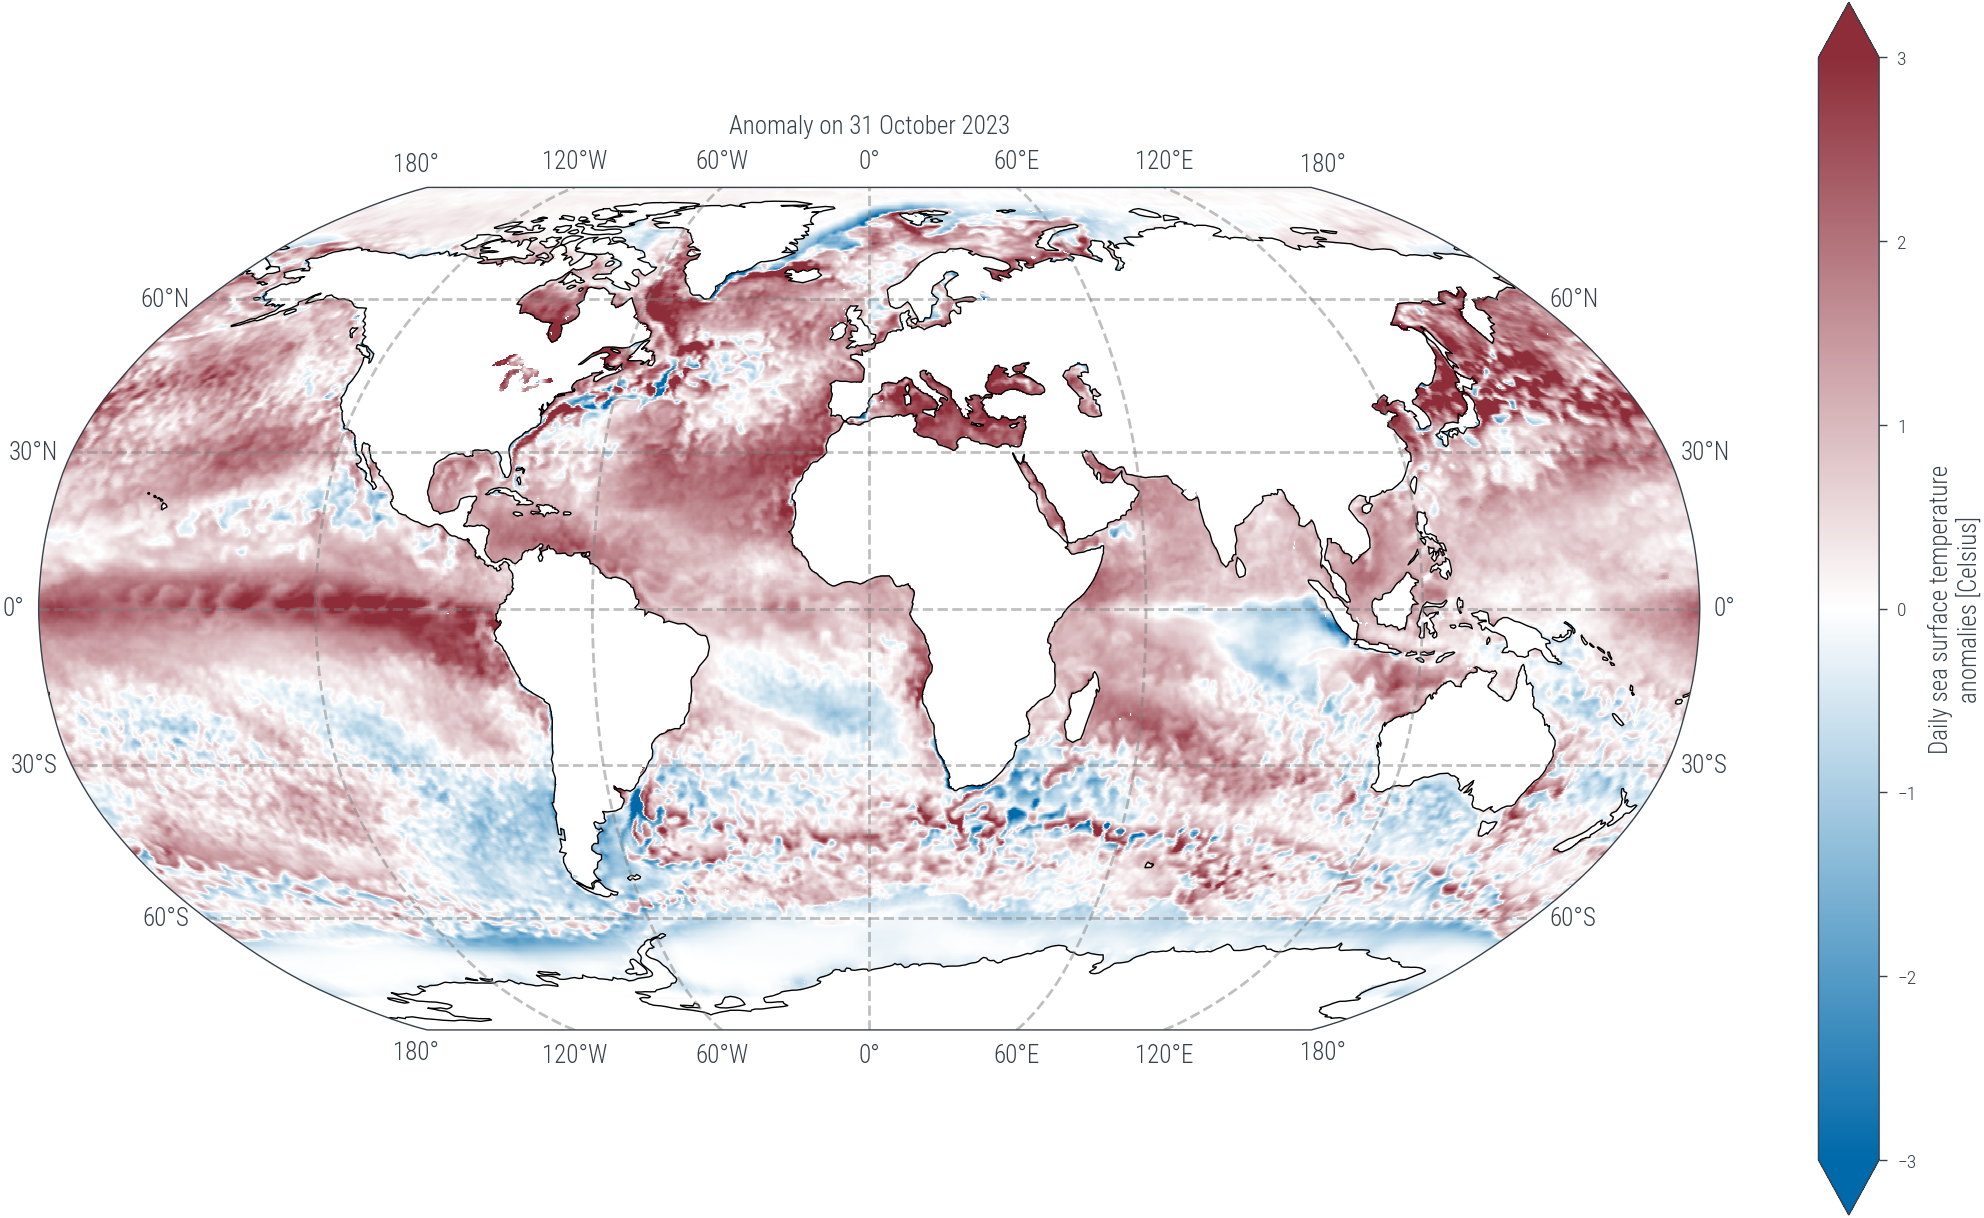

In [12]:
if BUILD_ANIMATIONS:
    plt.rcParams["animation.html"] = "jshtml"

    # Create a figure and axis with cartopy projection
    plt.rcParams.update(bundles.beamer_moml())
    fig = plt.figure(figsize=(10, 6.15))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
    ax.coastlines()
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=1,
        color="gray",
        alpha=0.5,
        linestyle="--",
    )
    gl.top_labels = True
    gl.right_labels = True


    im = anom[0].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=rb, vmin=-3, vmax=3)
    date_str = anom.time[0].values.astype("datetime64[D]").astype(str)
    date_str = pd.to_datetime(date_str).strftime("%d %B %Y")
    plt.title(f"Anomaly on {date_str}")


    # Define the update function for the animation
    def update(frame):
        # Clear the previous plot
        im.set_array(anom[frame].values.ravel())

        # Update the title for the current frame
        date_str = anom.time[frame].values.astype("datetime64[D]").astype(str)
        date_str = pd.to_datetime(date_str).strftime("%d %B %Y")
        plt.title(f"Anomaly on {date_str}")
        return [im]


    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=len(anom), blit=True, interval=33)

    # Set the DPI of the output video
    dpi = 300

    ani.save("sst_without_ice.mp4", dpi=dpi)

    ani

This view gives a good impression of the development of sea surface temperature across the year. To see how this affects ice in the Antarctic, we rotate to a pole-centric view, and also plot ice cover. 

/Users/philipp/teaching_git/2025_WS_DataLiteracy/DataLitEnv/lib/python3.13/site-packages/cartopy/crs.py:181: UserWarning: The 'NearsidePerspective' projection does not handle elliptical globes.
  warnings.warn(f'The {self.__class__.__name__!r} projection '


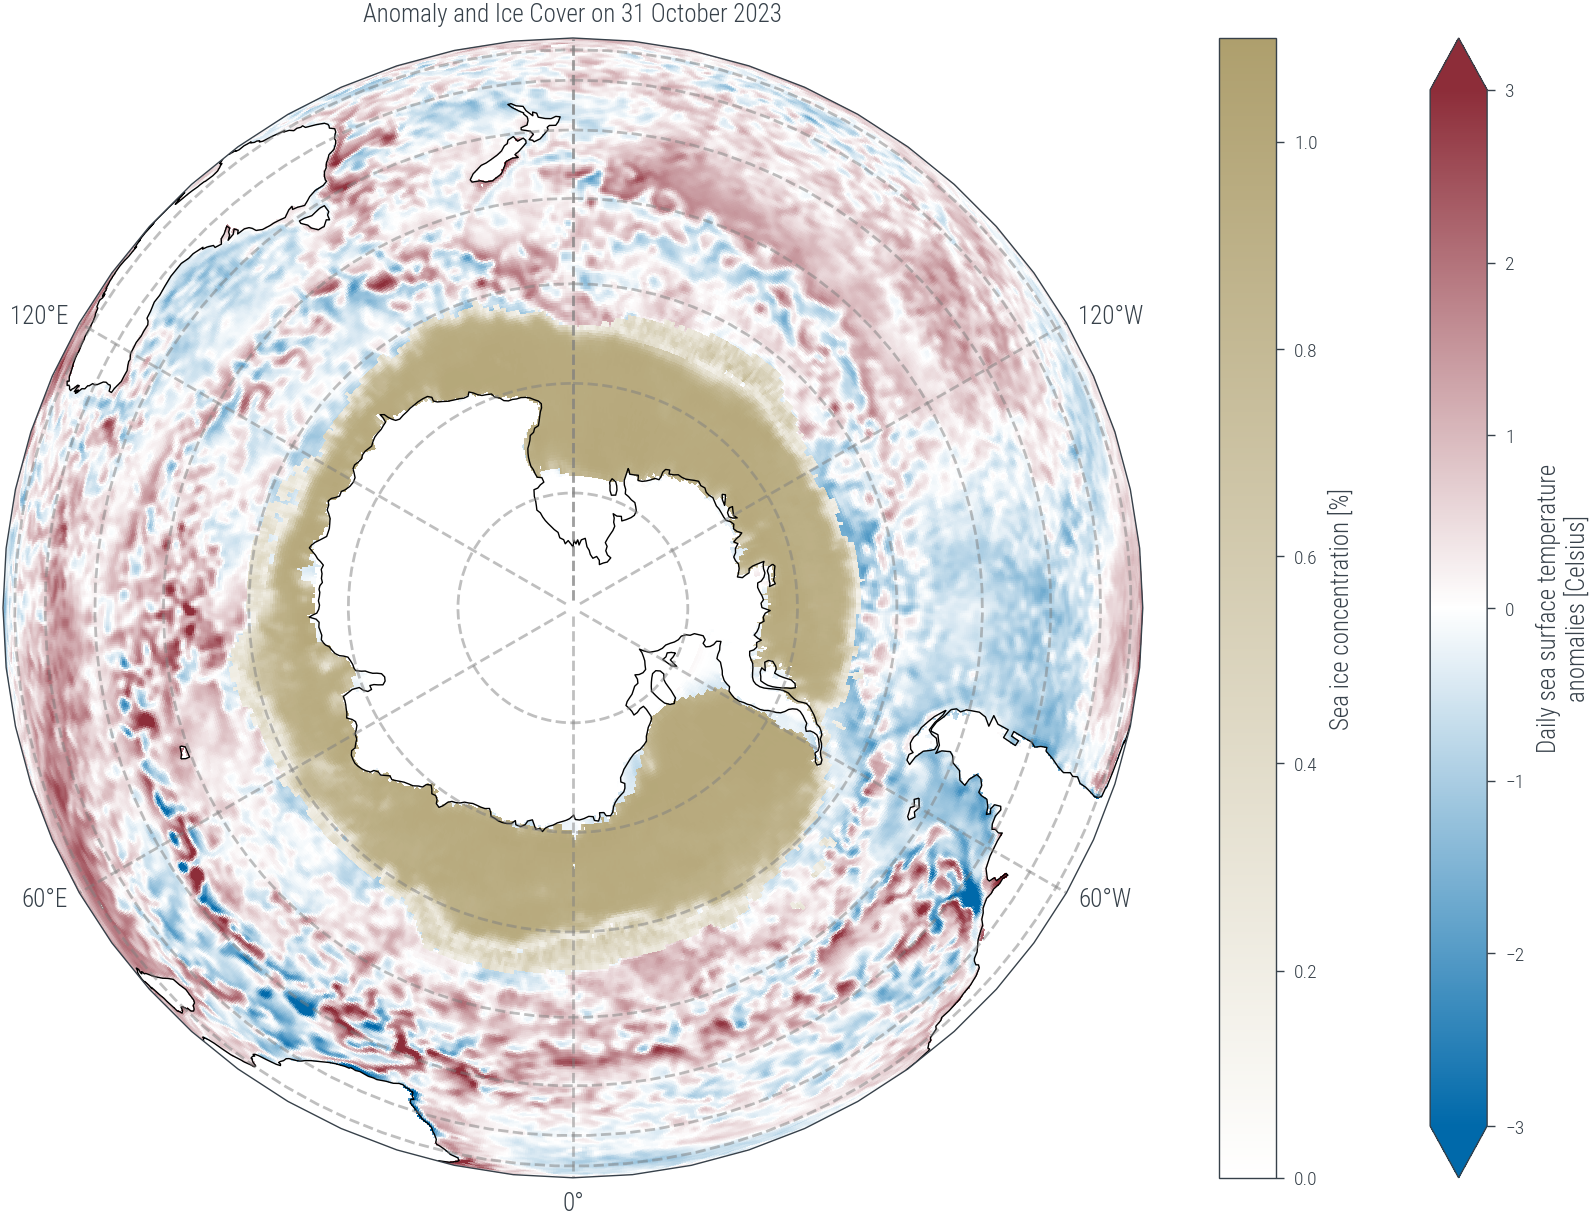

In [13]:
if BUILD_ANIMATIONS:
    plt.rcParams["animation.html"] = "jshtml"

    # Create a figure and axis with cartopy projection
    fig = plt.figure(figsize=(10, 6.15))
    lat = 0
    lon = -90
    ax = fig.add_subplot(
        1,
        1,
        1,
        projection=ccrs.NearsidePerspective(
            central_longitude=-180, central_latitude=-90, globe=ccrs.Globe()
        ),
    )
    ax.coastlines()
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=1,
        color="gray",
        alpha=0.5,
        linestyle="--",
    )
    gl.top_labels = False
    gl.right_labels = False


    im = anom[0].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=rb, vmin=-3, vmax=3)
    im2 = ice[0].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=wg, vmin=0, vmax=1.1)
    date_str = anom.time[0].values.astype("datetime64[D]").astype(str)
    date_str = pd.to_datetime(date_str).strftime("%d %B %Y")
    plt.title(f"Anomaly and Ice Cover on {date_str}")


    # Define the update function for the animation
    def update(frame):
        # Clear the previous plot
        im.set_array(anom[frame].values.ravel())
        im2.set_array(ice[frame].values.ravel())

        # Update the title for the current frame
        date_str = anom.time[frame].values.astype("datetime64[D]").astype(str)
        date_str = pd.to_datetime(date_str).strftime("%d %B %Y")
        plt.title(f"Anomaly and Ice Cover on {date_str}")
        return [im]


    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=len(anom), blit=True, interval=33)

    # Set the DPI of the output video
    dpi = 300


    ani.save("sst.mp4", dpi=dpi)

    ani

## So what is going on?

Of course, a proper ``scientific'' answer (for whatever that may mean) is too much to ask for in a short lecture segment. But it may be useful to know that such high-level global weather analysis is often considered in the context of long-term large-scale weather patterns, like the El Niño Southern Oscillation (ENSO). It may be surprising to hear, but this pattern actually emerges from a relatively simple principal component analysis of the SST time series. We can even do it in this little jupyter notebook:

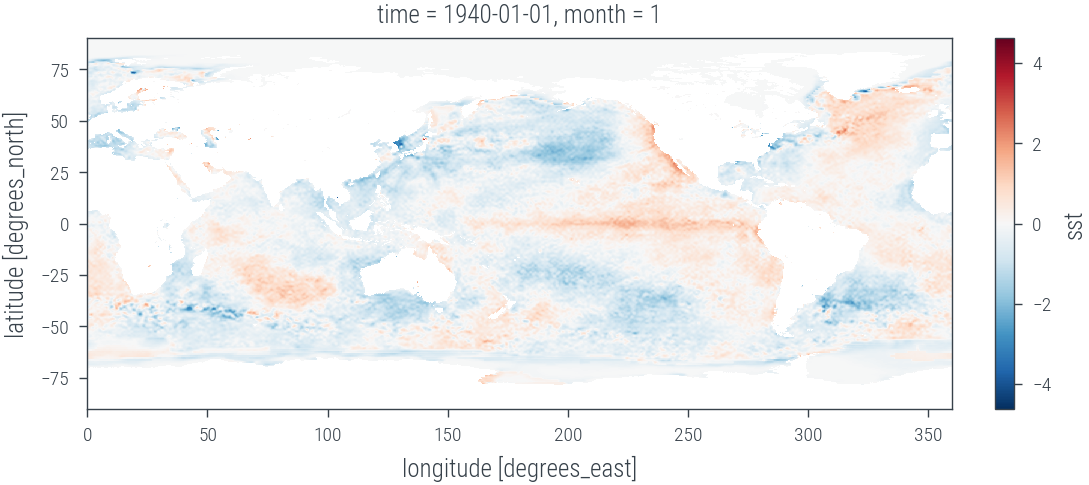

In [14]:
import xarray as xr

# load the ERA5 SST data, 1 Jan / Jul, from 1940 to 2020. 
# Sea surface temperature
x_map = xr.open_dataset("era_5_sst_monthly_reanalysis_JANJUL_1940-2023.nc")['sst']
# the daily dataset would be 66GB in size, so we only use two days per year

# Compute monthly anomalies
anomaly = x_map.groupby('time.month') - x_map.groupby('time.month').mean(dim='time')

# Plot a map
anomaly.isel(time=0).plot()

### PCA:

In [15]:
# Flatten maps and standardize
x_flat = anomaly.stack(z=('latitude', 'longitude'))
# Remove NaNs
mask_nan = x_flat.isnull().any(dim='time')
x_flat = x_flat[:, ~mask_nan]

# Standardize values
X = x_flat.values
X = (X - X.mean() ) / X.std() 
X.shape

(168, 686363)

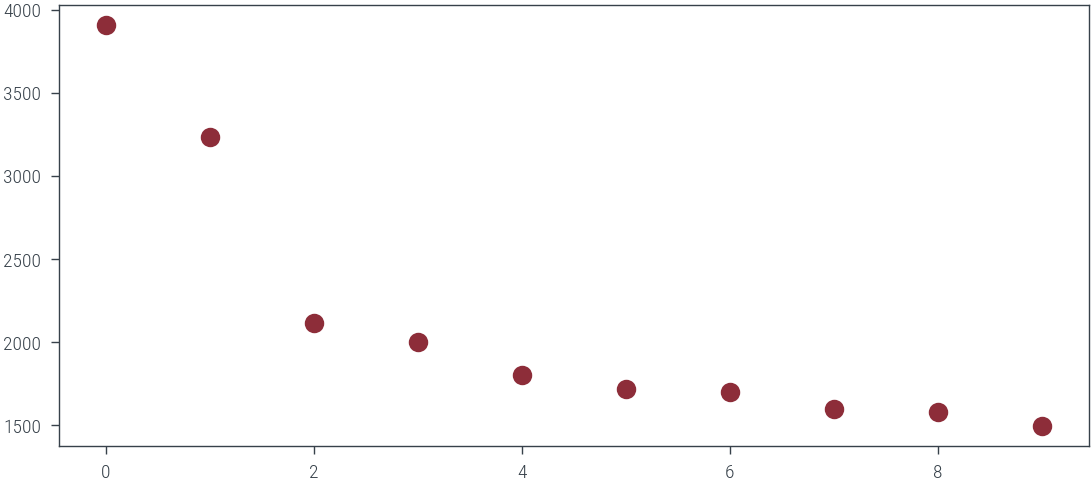

In [16]:
from scipy.sparse.linalg import svds

# Compute SVD
# because this is a rather large matrix, we'll only compute the first 3 components. 
# The efficient way to do this via the Lanczos svd. This is a randomized method, so we need to set a seed for reproducibility.
k = 10 # number of components
rng = np.random.default_rng(1)
U, S, V = svds(X, k=k, random_state=rng)

# Sort eigenvalues and their eigenvectors 
ids_sort = S.argsort()[::-1]
S, V = S[ids_sort], V[ids_sort,:] 

# reshape
pcs = xr.DataArray(X @ V.T, 
                   coords={'time': x_flat.time, 'n_components': np.arange(1, k+1)}) 
eofs = xr.DataArray(V.T, coords={'z': x_flat.z, 'n_components': np.arange(1, k+1)}).unstack('z')
eofs = eofs.sortby('longitude')

plt.plot(S,'o')


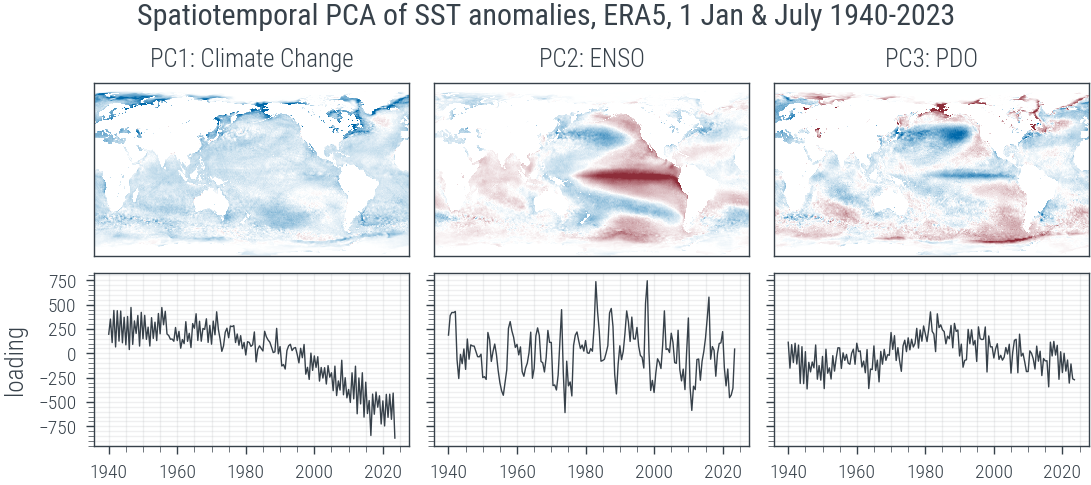

In [17]:
# Plot EOFs and PCs
fig, axs = plt.subplots(2,3, sharey = "row")

titles = ["PC1: Climate Change", "PC2: ENSO", "PC3: PDO"]

for i in range(3):
    eofs.isel(n_components=i).plot(ax=axs[0,i], cmap=rb, add_colorbar=False, vmin=-0.005, vmax=0.005)
    pcs.isel(n_components=i).plot(ax=axs[1,i], linewidth=0.5, color=rgb.tue_dark)

    axs[1,i].xaxis.set_major_locator(mdates.YearLocator(20))
    axs[1,i].xaxis.set_minor_locator(mdates.YearLocator(5))
    axs[0,i].set_title(titles[i])
    axs[1,i].set_title(None)
    # axs[1,i].set_ylim(-80, 80)

    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[0,i].set_xlabel(None)
    axs[0,i].set_ylabel(None)
    axs[1,i].set_xlabel(None)
    axs[1,i].grid(True, which='both', axis='both', color=rgb.tue_gray, linestyle='-', linewidth=0.5)


axs[1,0].set_ylabel("loading")
axs[1,0].yaxis.set_major_locator(plt.MultipleLocator(250))
axs[1,0].yaxis.set_minor_locator(plt.MultipleLocator(50))

plt.suptitle("Spatiotemporal PCA of SST anomalies, ERA5, 1 Jan & July 1940-2023")

plt.savefig("spatiotemporal_pca.png", dpi=600)